# Part 1: How to Explore the GAN Latent Space When Generating Faces (25 pts)

1. Implement SR-GAN on your own using PyTorch. (Ref: https://arxiv.org/abs/1609.04802)

2. Use the ImageNet dataset to run a few epochs to train the model. You may use the script provided here to generate training data: Dataset (https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/srgan/datasets.py). However, there is some issue with this code, hence the drive link for the generated images is shared below. Please use this link to access the dataset for training SRGAN. (https://drive.google.com/drive/folders/13txSH8LU64amnvY0hkxMxMI6F6ssbErG?usp=sharing ) .

Note: you should only use this repo for dataset code and reference. Model and results
(20 pts) + report (5 pts)

In [1]:
import glob
import random
import os
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms


# Configurations

In [2]:
! mkdir trained_model

mkdir: trained_model: File exists


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps"

LOAD_MODEL = True
SAVE_MODEL = True

CHECKPOINT_GEN = "trained_model/gen.pth.tar"
CHECKPOINT_DISC = "trained_model/disc.pth.tar"

LEARNING_RATE = 1e-4
NUM_EPOCHS = 32
BATCH_SIZE = 16

HIGH_RES = 96
LOW_RES = HIGH_RES // 4
IMG_CHANNELS = 3


base_data_path = "./SRGAN_Data/"

# Data Loading And Transformation

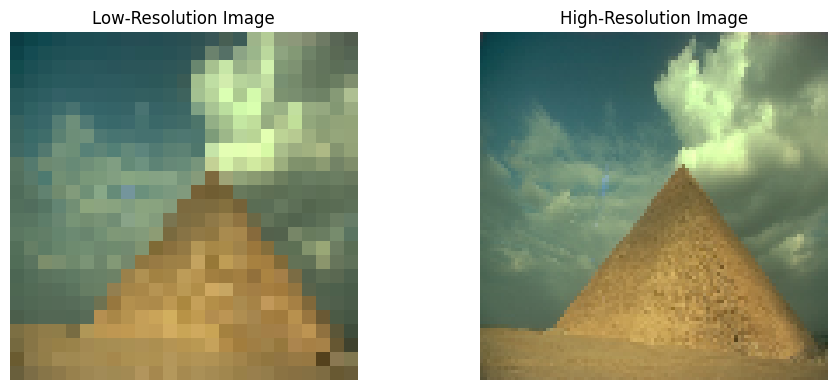

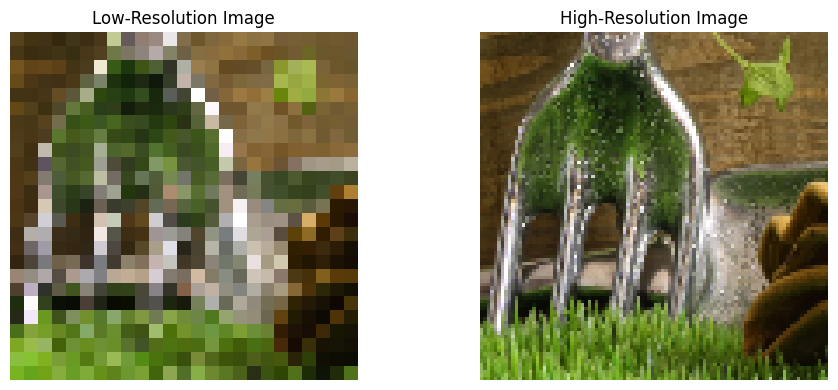

In [4]:
import matplotlib.pyplot as plt

def show_samples(data_path):
    lr_files = os.listdir(data_path + "/LR/")
    hr_files = os.listdir(data_path + "/HR/")
    
    
    for i in range(2):
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        image = Image.open(os.path.join(data_path + "/LR/", lr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Low-Resolution Image')

        plt.subplot(1, 2, 2)
        image = Image.open(os.path.join(data_path + "/HR/", hr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('High-Resolution Image')
        
        plt.tight_layout()
        plt.show()        
        
show_samples(base_data_path)

In [5]:
low_res_image = os.listdir(base_data_path + "/LR/")[0]
print("Low Resolution Image size = ", Image.open(os.path.join(base_data_path + "/LR/", low_res_image)).size)

hish_res_image = os.listdir(base_data_path + "/HR/")[0]
print("High Resolution Image size = ", Image.open(os.path.join(base_data_path + "/HR/", hish_res_image)).size)

Low Resolution Image size =  (25, 25)
High Resolution Image size =  (100, 100)


In [19]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImagePairDataset(Dataset):
    def __init__(self, root, hr_shape):
        hr_height, hr_width = hr_shape
        self.lr_transform = transforms.Compose([
            transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        self.hr_transform = transforms.Compose([
            transforms.Resize((hr_height, hr_height), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

        self.lr_files = sorted(glob.glob(root + "/LR/*.*"))
        self.hr_files = sorted(glob.glob(root + "/HR/*.*"))
        
        print(f"Number of low res images = {len(self.lr_files)}, and High res images = {len(self.hr_files)}")
        
        print("Image Sizes After transformation")
        print("Low Resolution Image size = ", self.lr_transform(Image.open(self.lr_files[0])).shape)
        print("High Resolution Image size = ", self.hr_transform(Image.open(self.hr_files[0])).shape)

    def __getitem__(self, index):
        img_lr = Image.open(self.lr_files[index])
        img_hr = Image.open(self.hr_files[index])

        img_lr = self.lr_transform(img_lr)
        img_hr = self.hr_transform(img_hr)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.lr_files)  # Each pair counts as one sample



dataset = ImagePairDataset(base_data_path, hr_shape=(96, 96))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Data Load is created with size = {len(dataloader)}")

Number of low res images = 509, and High res images = 509
Image Sizes After transformation
Low Resolution Image size =  torch.Size([3, 24, 24])
High Resolution Image size =  torch.Size([3, 96, 96])
Data Load is created with size = 32


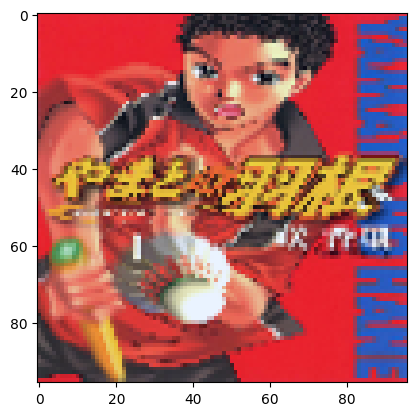

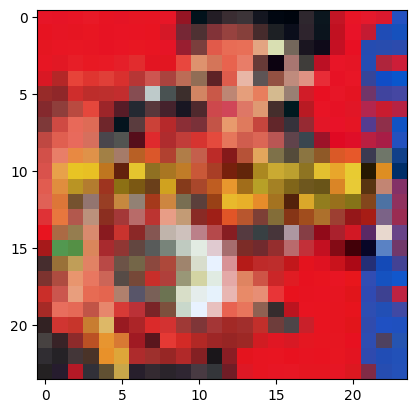

In [21]:
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

for data in dataloader:
    hr_img = data['hr']
    lr_img = data['lr']
    plt.imshow(normalize(hr_img[0].permute(1, 2, 0)))
    plt.figure()
    plt.imshow(normalize(lr_img[0].permute(1, 2, 0)))
    break

# Model

![Image Title](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-19_at_11.13.45_AM_zsF2pa7.png)

In [22]:
import torch
from torch import nn


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation_func=None, normalize=True, bias=True, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels, out_channels, bias=bias, **kwargs)
        self.batchNorm = nn.BatchNorm2d(out_channels) if normalize else nn.Identity()
        self.activation_func = activation_func
        

    def forward(self, x):
        out = self.cnn(x)
        out = self.batchNorm(out)
        if self.activation_func is not None:
            out = self.activation_func(out)
        return out


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # self.activation_func = nn.PReLU(num_parameters=in_channels)
        # first three layer of the residual block
        self.block_with_act = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1, activation_func=nn.PReLU(num_parameters=in_channels))
        # later 2 layer of the residual block
        self.block_wo_act = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = self.block_with_act(x)
        out = self.block_wo_act(out)
        return out + x


class PixelShufflerBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        out_channels = in_channels * scale_factor ** 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1) # in_c * 4, H, W --> in_c, H*2, W*2
        self.bn = nn.BatchNorm2d(out_channels)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.activation_function = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        out = self.conv(x)
        out = self.pixel_shuffle(out)
        out = self.activation_function(out)
        return out


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_res_blocks=16, num_pix_shuffle_blocks=2):
        super().__init__()
        self.first_layer = ConvBlock(in_channels, num_channels, activation_func=nn.PReLU(num_parameters=num_channels), kernel_size=9, stride=1, padding=4, normalize=False)
        self.residual_layer = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_res_blocks)])
        self.conv_layer = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle_layer = nn.Sequential(*[PixelShufflerBlock(num_channels, scale_factor=2) for _ in range(num_pix_shuffle_blocks)])
        self.output_layer = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.first_layer(x)
        out = self.residual_layer(initial)
        out = self.conv_layer(out) + initial
        out = self.pixel_shuffle_layer(out)
        out = self.output_layer(out)
        out = torch.tanh(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        activation_func = nn.LeakyReLU(0.2)
        self.layers = nn.Sequential(*[
            ConvBlock(in_channels, 64,  activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=False),
            ConvBlock(64,  64,  activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(64,  128, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(128, 128, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(128, 256, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(256, 256, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(256, 512, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(512, 512, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True)
        ])

        self.conv_out = nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1)
        # self.classifier = nn.Sequential(
        #     # nn.AdaptiveAvgPool2d((6, 6)),
        #     # nn.Flatten(),
        #     nn.Linear(512 * 6 * 6, 1024),
        #     nn.LeakyReLU(0.2),
        #     nn.Linear(1024, 1),
        # )

    def forward(self, x):
        # x = self.layers(x)
        
        out = self.layers(x)

        out = self.conv_out(out)
        
        return out


def test():
    x = torch.randn((5, 3, LOW_RES, LOW_RES))
    gen = Generator()
    gen_out = gen(x)
    # print(gen)
    print(gen_out.shape)
    disc = Discriminator()
    # print(disc)
    disc_out = disc(gen_out)
    print(disc_out.shape)


test()

torch.Size([5, 3, 96, 96])
torch.Size([5, 1, 6, 6])


In [23]:
from torchsummary import summary
print(Generator())
summary(Generator(), (3, 24, 24))

Generator(
  (first_layer): ConvBlock(
    (cnn): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (batchNorm): Identity()
    (activation_func): PReLU(num_parameters=64)
  )
  (residual_layer): Sequential(
    (0): ResidualBlock(
      (block_with_act): ConvBlock(
        (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_func): PReLU(num_parameters=64)
      )
      (block_wo_act): ConvBlock(
        (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (block_with_act): ConvBlock(
        (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [24]:
print(Discriminator())
summary(Discriminator(), (3, 96, 96))

Discriminator(
  (layers): Sequential(
    (0): ConvBlock(
      (cnn): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchNorm): Identity()
      (activation_func): LeakyReLU(negative_slope=0.2)
    )
    (1): ConvBlock(
      (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_func): LeakyReLU(negative_slope=0.2)
    )
    (2): ConvBlock(
      (cnn): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchNorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_func): LeakyReLU(negative_slope=0.2)
    )
    (3): ConvBlock(
      (cnn): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (batchNorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_func): LeakyReLU(negative_slope=0

# VGG Loss

In [36]:
import torch.nn as nn
from torchvision.models import vgg19, VGG19_Weights

class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # self.vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features[:18].eval().to(DEVICE)
        self.vgg = nn.Sequential(*list(vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features.children())[:18]).eval().to(DEVICE)
        self.loss = nn.L1Loss()

        for param in self.vgg.parameters():
            param.requires_grad = False
            
    def forward(self, preds, target):
        vgg_input_features = self.vgg(preds)
        vgg_target_features = self.vgg(target).detach()
        return self.loss(vgg_input_features, vgg_target_features)

In [37]:
VGGLoss()

VGGLoss(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

# Utils Functions

In [38]:
import torch
import os
import numpy as np
from PIL import Image
from torchvision.utils import save_image


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print(f"=> Saving checkpoint {filename}")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    if os.path.exists(checkpoint_file):
        print("=> Loading checkpoint")
        checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])

        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
    else:
        print("File does not exist.")
    
    return model, optimizer


# Training Evaluations

In [39]:
def generated_output(G, image):
    ts = transforms.Compose([
            transforms.Resize((24, 24), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    
    upscaled_img = ts(image).unsqueeze(0).to(DEVICE)
    gen_output = G(upscaled_img)
    gen_output = (gen_output.squeeze().permute(1, 2, 0).cpu().detach().numpy() + 1) * 0.5
    return upscaled_img, gen_output
    

def plot_examples(data_path, G):
    
    lr_files = os.listdir(data_path + "/LR/")
    hr_files = os.listdir(data_path + "/HR/")
    
    G.eval()
    for i in range(1):
        plt.figure(figsize=(15, 4))
        
        plt.subplot(1, 4, 1)
        image = Image.open(os.path.join(data_path + "/LR/", lr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Low-Resolution Image')

        transformed_lr, generated_img = generated_output(G, image)
        transformed_lr = (transformed_lr - transformed_lr.min()) / (transformed_lr.max() - transformed_lr.min())
        
        plt.subplot(1, 4, 2)
        plt.imshow(transformed_lr.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title('Transformed Image')
        
        plt.subplot(1, 4, 3)
        plt.imshow(generated_img)
        plt.axis('off')
        plt.title('Generated Image')
        
        plt.subplot(1, 4, 4)
        image = Image.open(os.path.join(data_path + "/HR/", hr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('High-Resolution Image')
        
        plt.tight_layout()
        plt.show()       
        

# Training Model

In [53]:
import torch
# import config
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm

torch.backends.cudnn.benchmark = True


def train_epoch(loader, D, G, opt_gen, opt_disc, mse_loss, bce_loss, vgg_loss_fun):
    
    training_metric = {"g_loss": [], "d_loss": [], "percp_loss": []}#, "l2_loss": []}

    D.train()
    G.train()
    for i, imgs in enumerate(loader):
        low_res = imgs['lr'].to(DEVICE)
        high_res = imgs['hr'].to(DEVICE)

        # Train Generator

        opt_gen.zero_grad()
        gen_high_res = G(low_res)
        disc_out = D(gen_high_res)

        g_adv_loss = mse_loss(disc_out, torch.ones_like(disc_out))
        # percp_loss = vgg_loss_fun(gen_high_res, high_res)
        percp_loss = mse_loss(gen_high_res, high_res)
        g_loss = percp_loss + 1e-3 * g_adv_loss

        g_loss.backward()
        opt_gen.step()

        # Train Discriminator

        opt_disc.zero_grad()
        disc_out_real = D(high_res)
        loss_real = mse_loss(disc_out_real, torch.ones_like(disc_out_real))

        disc_out_fake = D(gen_high_res.detach())
        loss_fake = mse_loss(disc_out_fake, torch.zeros_like(disc_out_fake))

        d_loss = (loss_real + loss_fake)

        d_loss.backward()
        opt_disc.step()

        
        if i % 10 == 9:
            print(f"\tg_loss: {g_loss.item()}, percp_loss: {percp_loss.item()}, d_loss: {d_loss.item()}")
            training_metric["g_loss"].append(g_loss.item())
            training_metric["d_loss"].append(d_loss.item())
            training_metric["percp_loss"].append(percp_loss.item())
            # training_metric["l2_loss"].append(l2_loss.item())

    return training_metric, D, G, opt_gen, opt_disc 

	g_loss: 0.9094528555870056, percp_loss: 0.9090312123298645, d_loss: 0.48009034991264343
	g_loss: 0.7332550287246704, percp_loss: 0.7326140403747559, d_loss: 0.28825223445892334
	g_loss: 0.6536651849746704, percp_loss: 0.6529839038848877, d_loss: 0.18979047238826752
epoch = 0 {'g_loss': 0.7654576897621155, 'd_loss': 0.31937768558661145, 'percp_loss': 0.7648763855298361}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


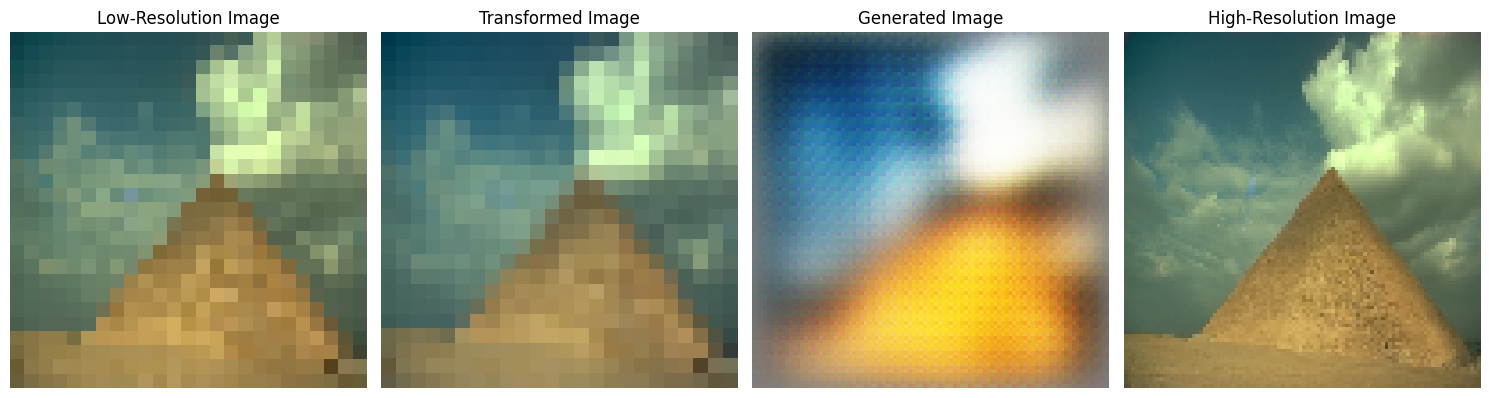

	g_loss: 0.7142716646194458, percp_loss: 0.7134960293769836, d_loss: 0.10366235673427582
	g_loss: 0.6070005297660828, percp_loss: 0.6061276197433472, d_loss: 0.08972376585006714
	g_loss: 0.5852807760238647, percp_loss: 0.5844377875328064, d_loss: 0.057608962059020996
epoch = 1 {'g_loss': 0.6355176568031311, 'd_loss': 0.08366502821445465, 'percp_loss': 0.6346871455510458}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


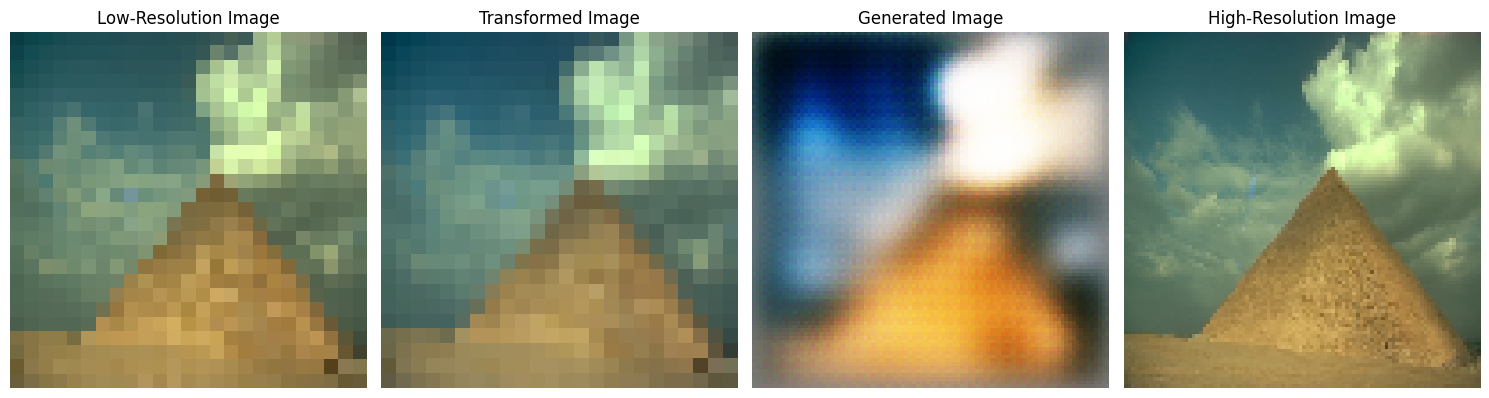

	g_loss: 0.5914302468299866, percp_loss: 0.5905548930168152, d_loss: 0.040812574326992035
	g_loss: 0.4801930785179138, percp_loss: 0.47920212149620056, d_loss: 0.03585340455174446
	g_loss: 0.6800150275230408, percp_loss: 0.6790117621421814, d_loss: 0.030360959470272064
epoch = 2 {'g_loss': 0.5838794509569804, 'd_loss': 0.03567564611633619, 'percp_loss': 0.5829229255517324}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


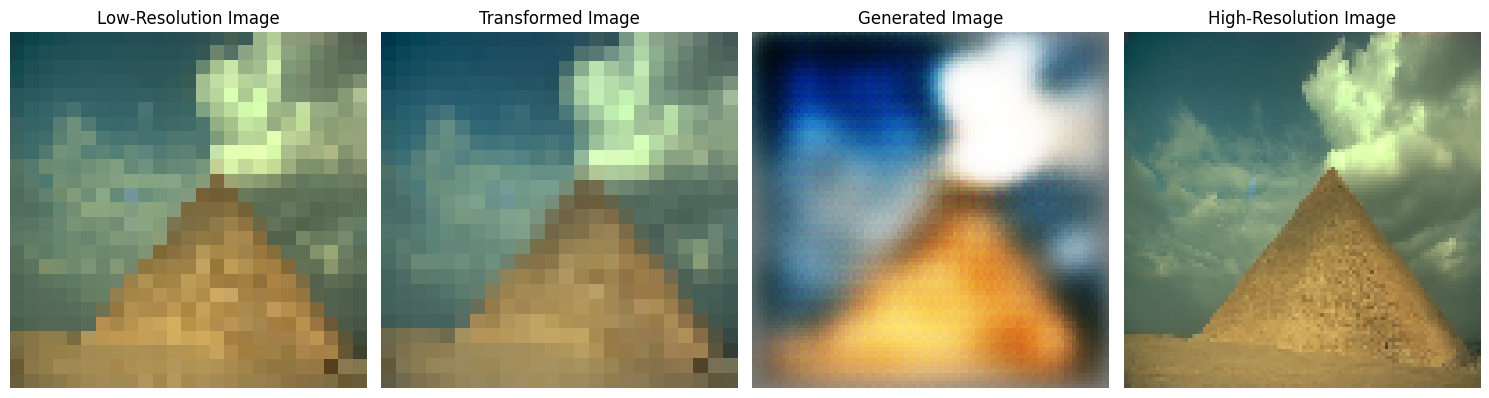

	g_loss: 0.5870876908302307, percp_loss: 0.5860506296157837, d_loss: 0.019971497356891632
	g_loss: 0.5372656583786011, percp_loss: 0.5363705158233643, d_loss: 0.024135056883096695
	g_loss: 0.5404961109161377, percp_loss: 0.5395737290382385, d_loss: 0.02067543752491474
epoch = 3 {'g_loss': 0.5549498200416565, 'd_loss': 0.02159399725496769, 'percp_loss': 0.5539982914924622}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


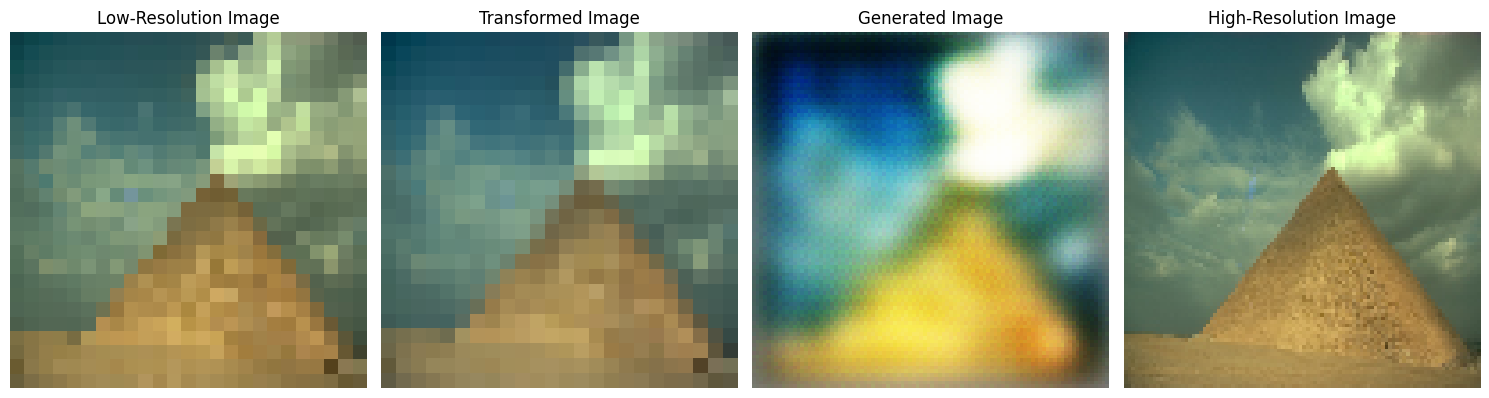

	g_loss: 0.5543444752693176, percp_loss: 0.5533189177513123, d_loss: 0.025452829897403717
	g_loss: 0.4498867690563202, percp_loss: 0.4488692879676819, d_loss: 0.03429707884788513
	g_loss: 0.6561663150787354, percp_loss: 0.6549472212791443, d_loss: 0.028283219784498215
epoch = 4 {'g_loss': 0.553465853134791, 'd_loss': 0.029344376176595688, 'percp_loss': 0.5523784756660461}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


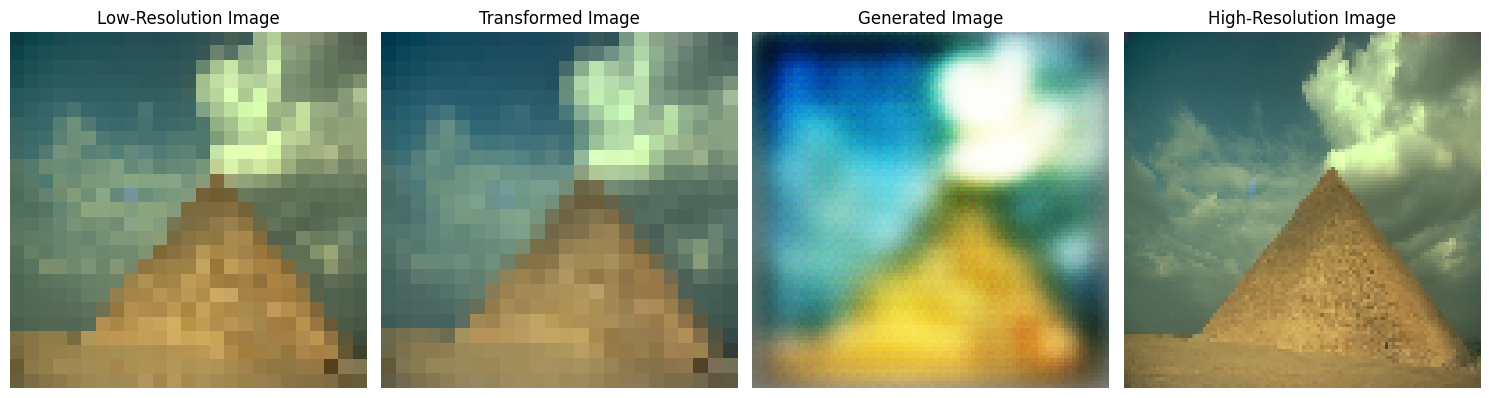

	g_loss: 0.5630934834480286, percp_loss: 0.5620238780975342, d_loss: 0.021464630961418152
	g_loss: 0.7358948588371277, percp_loss: 0.7347515225410461, d_loss: 0.02249392494559288
	g_loss: 0.49400264024734497, percp_loss: 0.4929387867450714, d_loss: 0.01578592136502266
epoch = 5 {'g_loss': 0.5976636608441671, 'd_loss': 0.019914825757344563, 'percp_loss': 0.5965713957945505}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


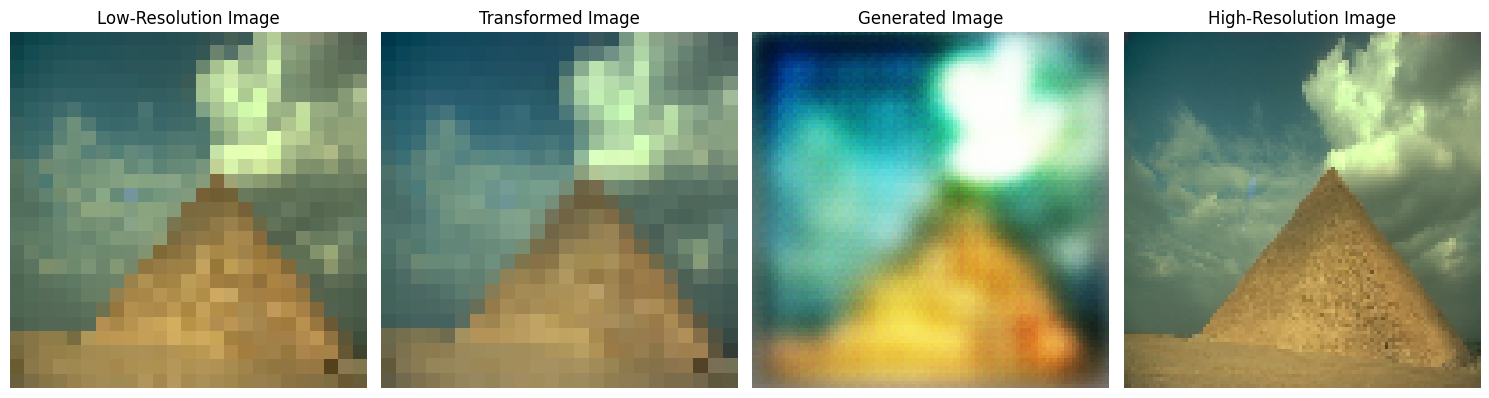

	g_loss: 0.41226693987846375, percp_loss: 0.411403626203537, d_loss: 0.026763852685689926
	g_loss: 0.5140624046325684, percp_loss: 0.5130656361579895, d_loss: 0.008548833429813385
	g_loss: 0.4870763123035431, percp_loss: 0.48621678352355957, d_loss: 0.01792169362306595
epoch = 6 {'g_loss': 0.4711352189381917, 'd_loss': 0.017744793246189754, 'percp_loss': 0.47022868196169537}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


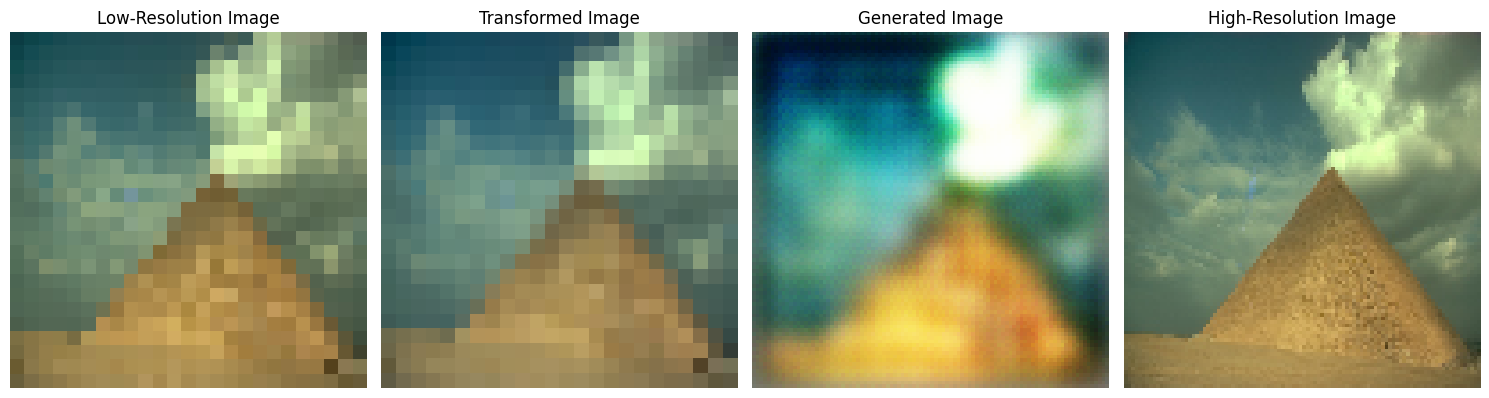

	g_loss: 0.42210662364959717, percp_loss: 0.4212128818035126, d_loss: 0.015513023361563683
	g_loss: 0.5415074229240417, percp_loss: 0.540527880191803, d_loss: 0.00898811686784029
	g_loss: 0.5565379858016968, percp_loss: 0.5554811954498291, d_loss: 0.00927126593887806
epoch = 7 {'g_loss': 0.5067173441251119, 'd_loss': 0.011257468722760677, 'percp_loss': 0.5057406524817148}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


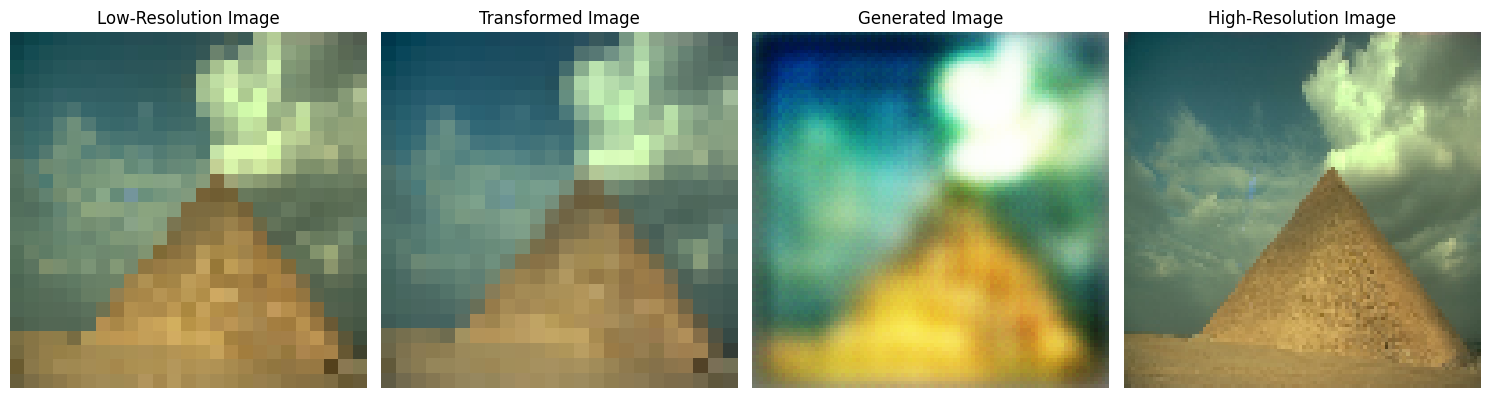

	g_loss: 0.641549825668335, percp_loss: 0.6405578851699829, d_loss: 0.007635812275111675
	g_loss: 0.555993914604187, percp_loss: 0.5550471544265747, d_loss: 0.0064569259993731976
	g_loss: 0.4396245777606964, percp_loss: 0.43859079480171204, d_loss: 0.00616763811558485
epoch = 8 {'g_loss': 0.5457227726777395, 'd_loss': 0.006753458796689908, 'percp_loss': 0.5447319447994232}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


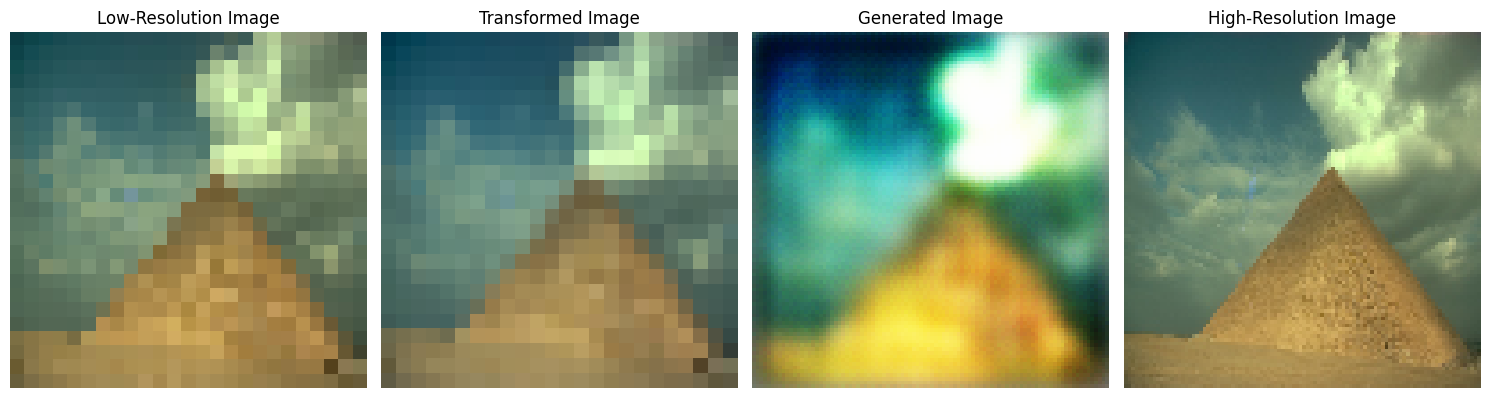

	g_loss: 0.4836605489253998, percp_loss: 0.4826142489910126, d_loss: 0.008170302957296371
	g_loss: 0.6282311081886292, percp_loss: 0.6272770762443542, d_loss: 0.005903748795390129
	g_loss: 0.5478342175483704, percp_loss: 0.5467188954353333, d_loss: 0.008816768415272236
epoch = 9 {'g_loss': 0.5532419582207998, 'd_loss': 0.007630273389319579, 'percp_loss': 0.5522034068902334}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


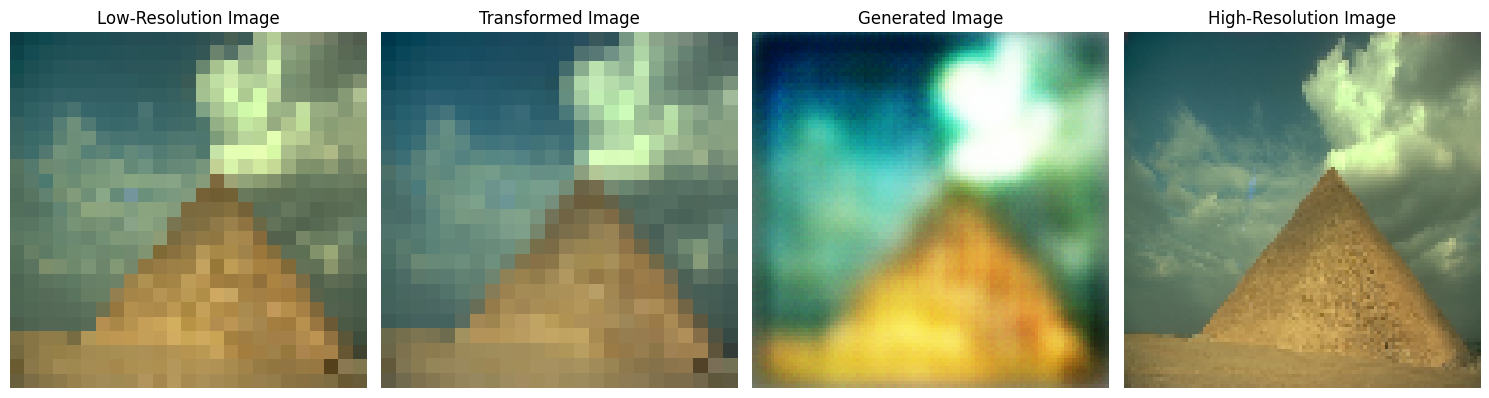

	g_loss: 0.690718948841095, percp_loss: 0.6897873282432556, d_loss: 0.007042578421533108
	g_loss: 0.4544776380062103, percp_loss: 0.45348528027534485, d_loss: 0.004462200216948986
	g_loss: 0.42569297552108765, percp_loss: 0.42471468448638916, d_loss: 0.004204347729682922
epoch = 10 {'g_loss': 0.5236298541227976, 'd_loss': 0.005236375456055005, 'percp_loss': 0.5226624310016632}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


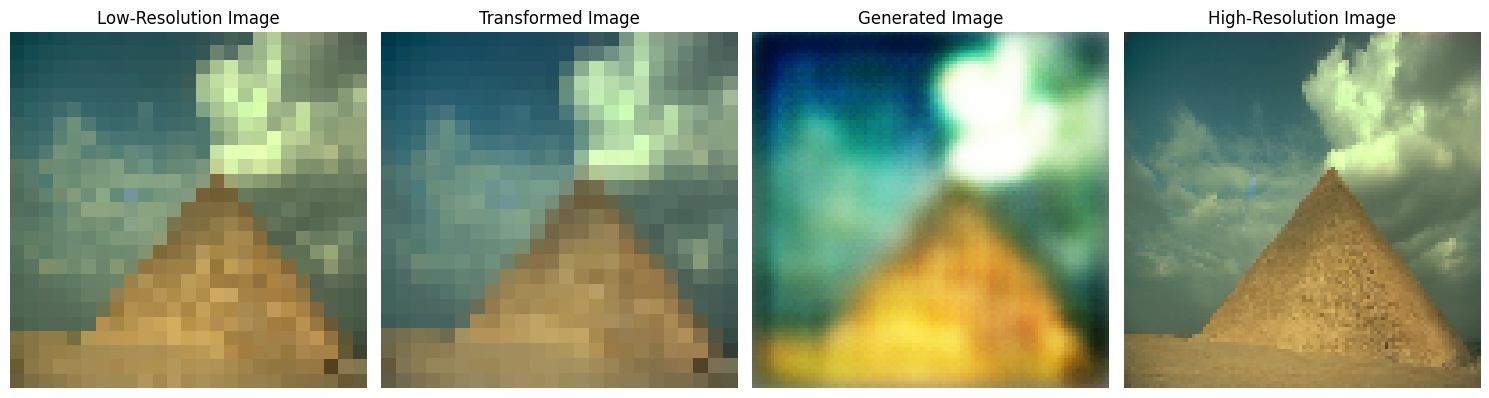

	g_loss: 0.5075871348381042, percp_loss: 0.5066186785697937, d_loss: 0.005621033720672131
	g_loss: 0.5657670497894287, percp_loss: 0.56474369764328, d_loss: 0.003956127446144819
	g_loss: 0.3454095125198364, percp_loss: 0.34437745809555054, d_loss: 0.008193181827664375
epoch = 11 {'g_loss': 0.4729212323824565, 'd_loss': 0.005923447664827108, 'percp_loss': 0.47191327810287476}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


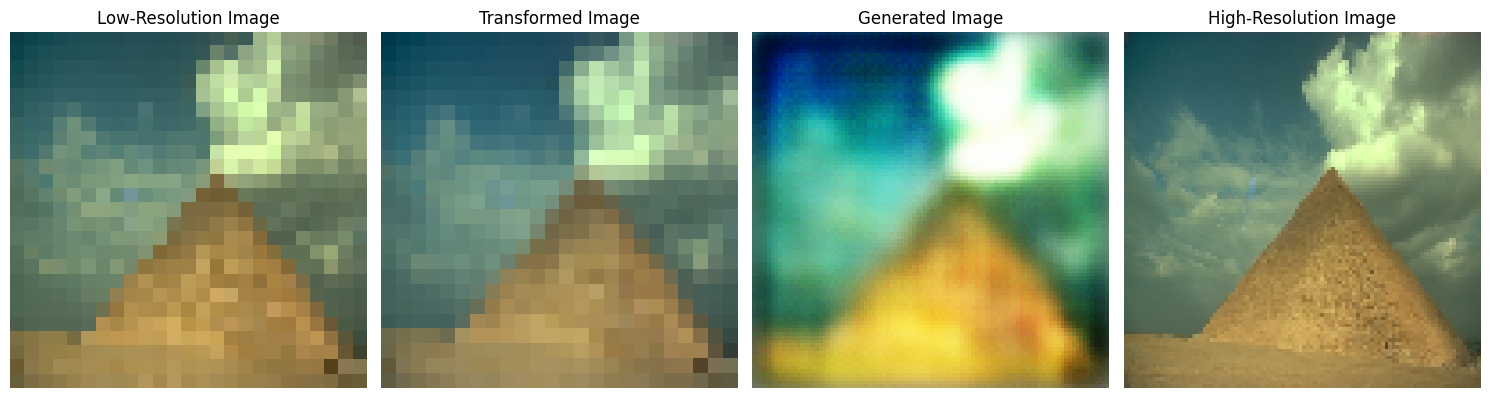

	g_loss: 0.45673441886901855, percp_loss: 0.455744206905365, d_loss: 0.005284890998154879
	g_loss: 0.4523375332355499, percp_loss: 0.4513028562068939, d_loss: 0.006626646034419537
	g_loss: 0.39982718229293823, percp_loss: 0.3988080322742462, d_loss: 0.0073375278152525425
epoch = 12 {'g_loss': 0.43629971146583557, 'd_loss': 0.006416354949275653, 'percp_loss': 0.4352850317955017}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


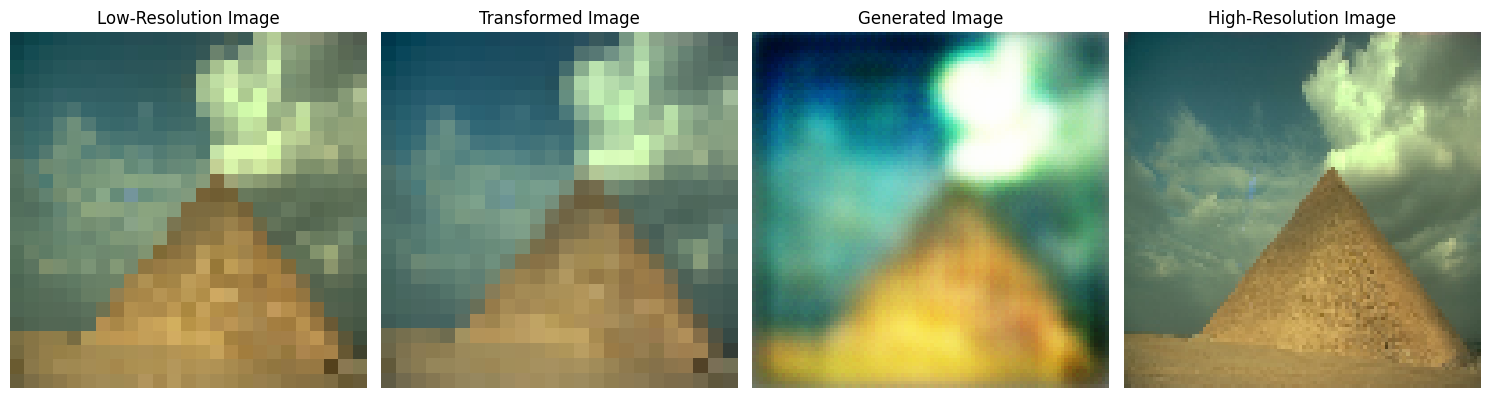

	g_loss: 0.5494754910469055, percp_loss: 0.5484578013420105, d_loss: 0.00413589458912611
	g_loss: 0.4661991596221924, percp_loss: 0.46519577503204346, d_loss: 0.004626709967851639
	g_loss: 0.503815770149231, percp_loss: 0.5028418302536011, d_loss: 0.004077541641891003
epoch = 13 {'g_loss': 0.506496806939443, 'd_loss': 0.00428004873295625, 'percp_loss': 0.505498468875885}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


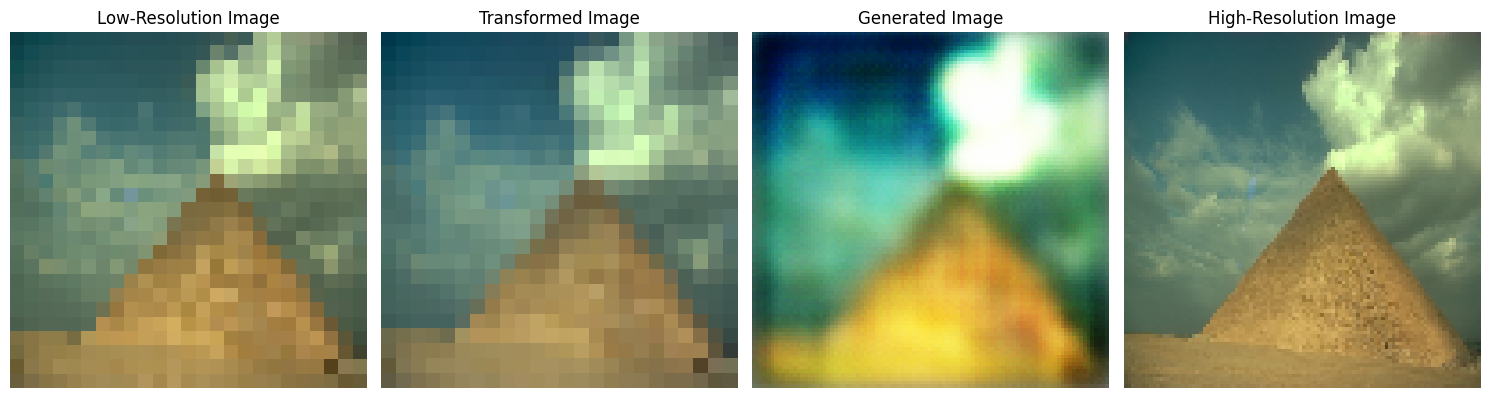

	g_loss: 0.3686859905719757, percp_loss: 0.3677414059638977, d_loss: 0.0065500494092702866
	g_loss: 0.5581232309341431, percp_loss: 0.557196855545044, d_loss: 0.006608712486922741
	g_loss: 0.5331239104270935, percp_loss: 0.5321659445762634, d_loss: 0.0037598791532218456
epoch = 14 {'g_loss': 0.48664437731107074, 'd_loss': 0.005639547016471624, 'percp_loss': 0.4857014020284017}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


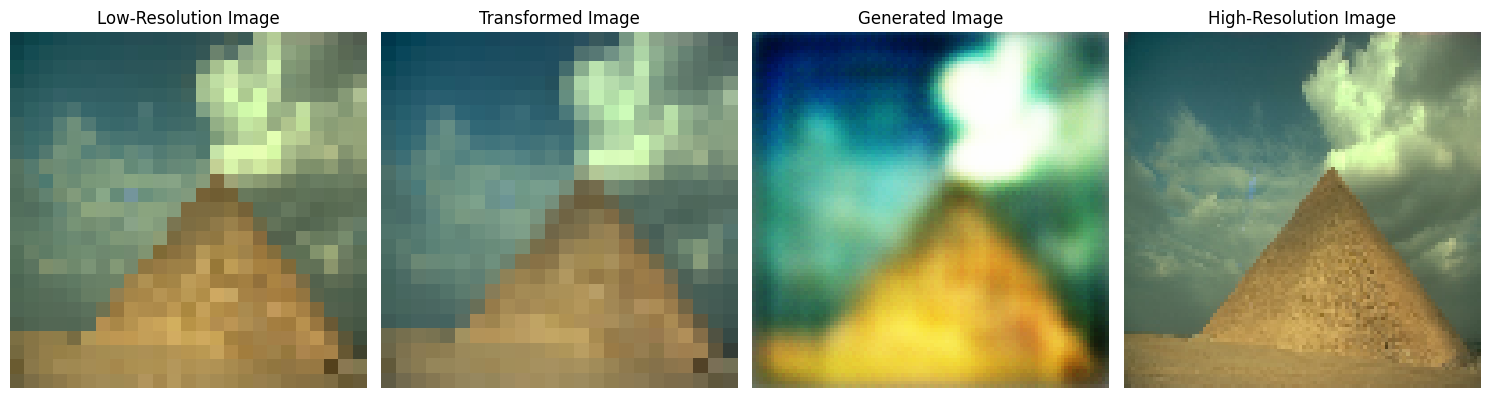

	g_loss: 0.5293434858322144, percp_loss: 0.5284075736999512, d_loss: 0.004853931255638599
	g_loss: 0.3952834904193878, percp_loss: 0.39426389336586, d_loss: 0.004219580441713333
	g_loss: 0.6341955661773682, percp_loss: 0.6331866383552551, d_loss: 0.0032717199064791203
epoch = 15 {'g_loss': 0.5196075141429901, 'd_loss': 0.004115077201277018, 'percp_loss': 0.5186193684736887}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


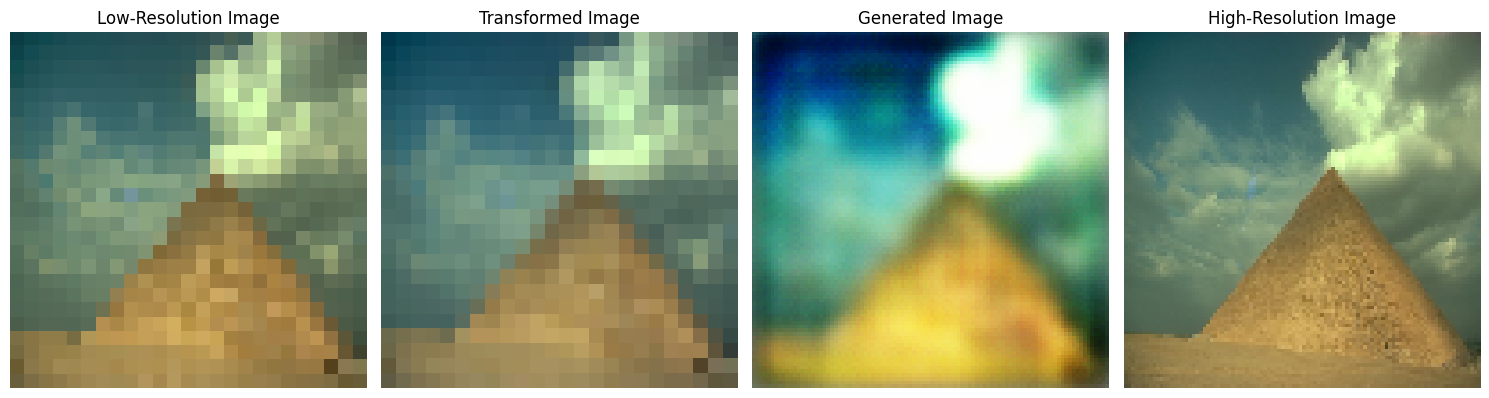

	g_loss: 0.4039326310157776, percp_loss: 0.4029141962528229, d_loss: 0.003174099139869213
	g_loss: 0.4591246545314789, percp_loss: 0.4581109881401062, d_loss: 0.002497678156942129
	g_loss: 0.4495774507522583, percp_loss: 0.4486011862754822, d_loss: 0.003136520739644766
epoch = 16 {'g_loss': 0.43754491209983826, 'd_loss': 0.0029360993454853692, 'percp_loss': 0.4365421235561371}
=> Saving checkpoint trained_model/gen.pth.tar
=> Saving checkpoint trained_model/disc.pth.tar


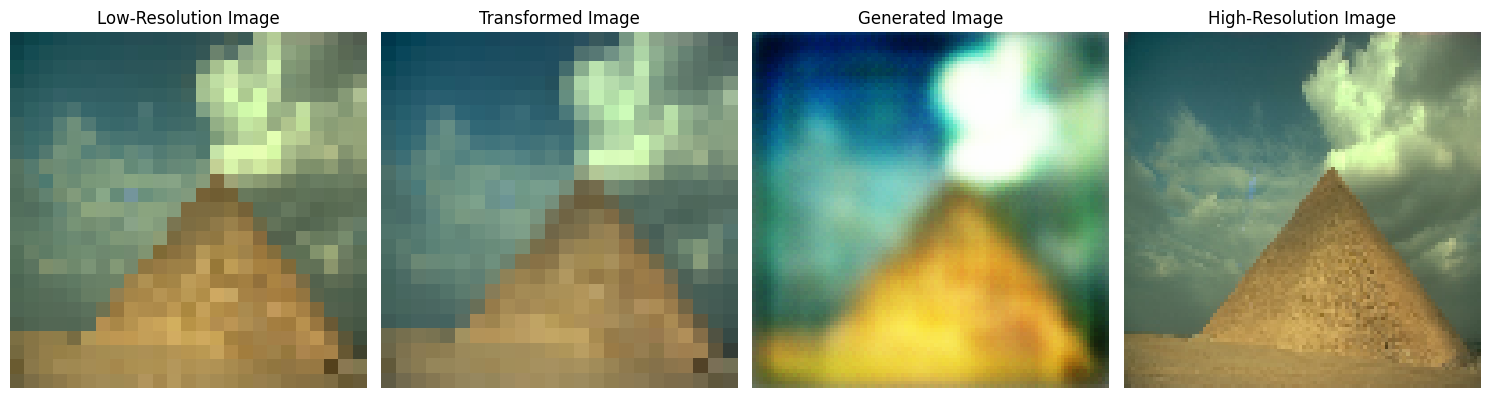

	g_loss: 0.530668318271637, percp_loss: 0.5296528339385986, d_loss: 0.003011697670444846


In [54]:
G = Generator().to(DEVICE)
G_optimizer = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))

D = Discriminator().to(DEVICE)
D_optimizer = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))


if False:
    load_checkpoint(CHECKPOINT_GEN, G, G_optimizer, LEARNING_RATE)
    load_checkpoint(CHECKPOINT_DISC, D, D_optimizer, LEARNING_RATE)
    print("Loaded Model Successfully")

training_metric = {"g_loss": [], "d_loss": [], "percp_loss": []}#, "l2_loss": []}

for epoch in range(100):
    epoch_metric, D, G, G_optimizer, D_optimizer = train_epoch(dataloader, D, G, G_optimizer, D_optimizer, 
                                                               nn.MSELoss(), nn.BCEWithLogitsLoss(), VGGLoss())

    for key in epoch_metric.keys():
        training_metric[key].append(np.mean(epoch_metric[key]))
    print(f"{epoch = }", {k: training_metric[k][-1] for k in training_metric.keys()})

    if SAVE_MODEL:
        save_checkpoint(G, G_optimizer, filename=CHECKPOINT_GEN)
        save_checkpoint(D, D_optimizer, filename=CHECKPOINT_DISC)
    
    plot_examples(base_data_path, G)
    # if epoch % 10 == 9:
    #     plot_examples(base_data_path, G)

# Model Evaluation

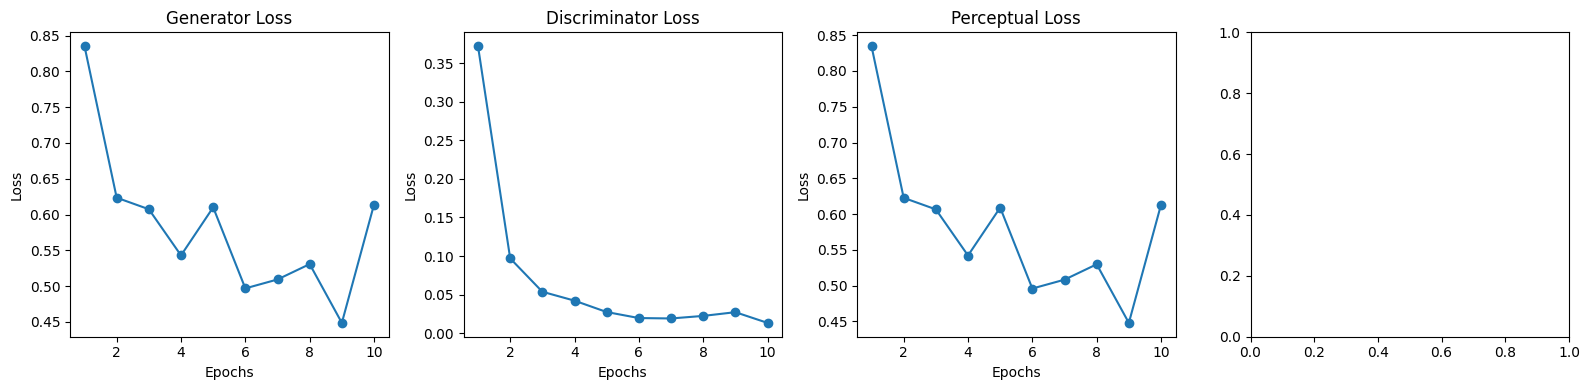

In [52]:
def plot_training_metrics(training_metric):
    num_epochs = len(training_metric['g_loss'])
    epochs = np.arange(1, num_epochs + 1)  # Assuming start from 1, adjust if needed

    # Plotting side by side without epoch axis
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # Plot g_loss
    axs[0].plot(epochs, training_metric['g_loss'], marker='o')
    axs[0].set_title('Generator Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

    # Plot d_loss
    axs[1].plot(epochs, training_metric['d_loss'], marker='o')
    axs[1].set_title('Discriminator Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')

    # Plot vgg_loss
    axs[2].plot(epochs, training_metric['percp_loss'], marker='o')
    axs[2].set_title('Perceptual Loss')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Loss')

    # Plot l2_loss
    # axs[3].plot(epochs, training_metric['l2_loss'], marker='o')
    # axs[3].set_title('L2 Loss')
    # axs[3].set_xlabel('Epochs')
    # axs[3].set_ylabel('Loss')

    plt.tight_layout()
    plt.show()
    
plot_training_metrics(training_metric)

In [ ]:
print("Showing Sample images generated by the model")
plot_examples(base_data_path, G)